In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import sys
from keras.models import load_model
from netCDF4 import Dataset
import os
from tools import Ps_to_sea_level, Ps_to_sea_level_old, load_ERA_variables, load_WProf_variables
from scipy import interpolate

2023-03-20 12:10:57.311765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 12:10:57.311790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
GEO = True
ERA = True
SURF = True

ALTITUDE = 1340
LATITUDE = -71.9
LONGITUDE = 23.3

PLOT = True
MODIFY_NC = True


In [ ]:
## Function which defines the corresponding dataframe and runs the retrieval model
## Note: this uses some of the pre-defined fields!!
def predict(lwp_or_pwv):
    if (not GEO) and ERA and SURF:
        df = pd.DataFrame({'Ts':Ts,'Ps':Ps,'RHs':RHs, 'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['LWPera','PWVera','Ps','RHs','TB','Ts','TB2'])
        mean = np.load('parameters/ERA_noGeo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/ERA_noGeo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/ERA_noGeo_Surf/%smodel_ERA_noGeo_Surf_TB12'%lwp_or_pwv)
    if GEO and ERA and SURF:
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date, 'Ts':Ts,'Ps':Ps,'RHs':RHs, 'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['LWPera','PWVera', 'Ps', 'RHs', 'TB', 'Ts', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/ERA_Geo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/ERA_Geo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/ERA_Geo_Surf/%smodel_ERA_Geo_Surf_TB12'%lwp_or_pwv)
    if GEO and ERA and (not SURF):
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date,  'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['LWPera', 'PWVera', 'TB', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/ERA_Geo_noSurf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/ERA_Geo_noSurf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/ERA_Geo_noSurf/%smodel_ERA_Geo_noSurf_TB12'%lwp_or_pwv)

    if (not GEO) and (not ERA) and SURF:
        df = pd.DataFrame({'Ts':Ts,'Ps':Ps,'RHs':RHs, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['Ps','RHs','TB','Ts','TB2'])
        mean = np.load('parameters/noERA_noGeo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/noERA_noGeo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/noERA_noGeo_Surf/%smodel_noERA_noGeo_Surf_TB12'%lwp_or_pwv)
    if GEO and (not ERA) and SURF:
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date, 'Ts':Ts,'Ps':Ps,'RHs':RHs, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['Ps', 'RHs', 'TB', 'Ts', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/noERA_Geo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/noERA_Geo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/noERA_Geo_Surf/%smodel_noERA_Geo_Surf_TB12'%lwp_or_pwv)
    if GEO and (not ERA) and (not SURF):
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date,'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['TB', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/noERA_Geo_noSurf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/noERA_Geo_noSurf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/noERA_Geo_noSurf/%smodel_noERA_Geo_noSurf_TB12'%lwp_or_pwv)


    # Normalize the input features
    npdf = (df.to_numpy()-mean)/std
    # Run the prediction
    pred = model.predict(npdf)
    # This ensures that there are no doubles (safety)
    tpred,inds = np.unique(t,return_index=True)
    pred = pred[inds]
    
    return (tpred,pred)

In [3]:


fwps = sorted(glob.glob('/ltenas3/POPE_2020/WProf_w_LWP_IWV/2002*.nc'))[:]#[20] #nas3/anneclaire/ICEGENESIS_2021/WProf/LV1_20210507/2101*.nc'))[:-2]

if PLOT:
    fig,axs = plt.subplots(2)

for fwp in fwps[:]:
    try:
        print(fwp)
        erapath = '/home/billault/Documents/In_progress/POPE_2020/ERA5_LWP_2020_02.nc'

        (t, Ts, Ps, RHs, TB, LWPrpg) = load_WProf_variables(fwp)
        (LWPera, PWVera) = load_ERA_variables(erapath, t)

        Ps = Ps_to_sea_level(np.array(Ps), np.array(Ts), ALTITUDE)

        Ts = Ts-273.15
        Ps = Ps*1e2

        daynum = []
        for tt in t:
            dt = datetime.datetime.utcfromtimestamp(tt)
            yr = dt.year
            daynum.append((dt-datetime.datetime(yr,1,1,0)).days+1+(dt-datetime.datetime(yr,1,1,0)).seconds/(24*3600))
        date = np.array(daynum)

        alt = np.zeros(len(TB))+ALTITUDE
        lat = np.zeros(len(TB))+LATITUDE
        lon = np.zeros(len(TB))+LONGITUDE

        tpwv,PWVpred = predict('PWV')
        tlwp,LWPpred = predict('LWP')

        if PLOT:
            axs[0].plot(tpwv,PWVpred)
            axs[1].plot(tpwv,LWPpred)

        if MODIFY_NC:
            with Dataset(fwp,'r+') as nc:
                if 'Liquid-water-path-RPG' in nc.variables.keys():
                    print('already done')
                    continue
                    
                nc.radar_name= 'WProf - RPG Demonstrator'
                nc.radar_manufacturer= 'RPG-Radiometer Physics GmbH'
                nc.radar_frequency= 94
                nc.radar_frequency_unit= 'GHz'
                nc.radar_type= 'Vertically pointing FMCW Doppler spectral'
                nc.radar_latitude= LATITUDE
                nc.radar_latitude_unit= 'degN'
                nc.radar_longitude= LONGITUDE
                nc.radar_longitude_unit= 'degE'
                nc.radar_altitude= ALTITUDE
                nc.radar_altitude_unit= 'm a.s.l.'
                nc.liquid_water_path_and_integrated_water_vapor_computation = 'Billault-Roux, A.-C. and Berne, A.: https://doi.org/10.5194/amt-2020-311'


                pwv = nc.createVariable('Integrated-water-vapor', 'f4',('Time',))
                pwv[:] = PWVpred[:]
                pwv.unit = 'kg.m^-2'
                pwv.description = 'integrated water vapor - Billault-Roux and Berne 2021 (https://doi.org/10.5194/amt-2020-311)'

                nc.renameVariable('Liquid-water-path', 'Liquid-water-path-RPG')
                nc.variables['Liquid-water-path-RPG'].description= 'liquid water path - computed through radar built-in software'
                nc.variables['Liquid-water-path-RPG'].unit= 'g.m^-2'

                lwp = nc.createVariable('Liquid-water-path', 'f4',('Time',))
                lwp[:] = LWPpred[:]
                lwp.unit = 'g.m^-2'
                lwp.description = 'liquid water path - Billault-Roux and Berne 2021 (https://doi.org/10.5194/amt-2020-311)'

    except Exception as e:
        print(fwp, e)

NameError: name 'glob' is not defined

/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_000004_P01_ZEN_LV2.nc 11.451564
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_010004_P01_ZEN_LV2.nc 11.651341
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_020004_P01_ZEN_LV2.nc 11.837756
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_030002_P01_ZEN_LV2.nc 13.982589
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_040005_P01_ZEN_LV2.nc 17.236702
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_050004_P01_ZEN_LV2.nc 29.917408
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_060003_P01_ZEN_LV2.nc 25.087465
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_070003_P01_ZEN_LV2.nc 18.765194
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_080004_P01_ZEN_LV2.nc 15.066031
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_090005_P01_ZEN_LV2.nc 14.443489
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_100003_P01_ZEN_LV2.nc 15.476044
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_110004_P01_ZEN_LV2.nc 14.928123
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191224_120004_P01_ZEN_LV2.nc 15.530921
/ltenas3/POPE_2020/WProf_w_LWP_IWV/191

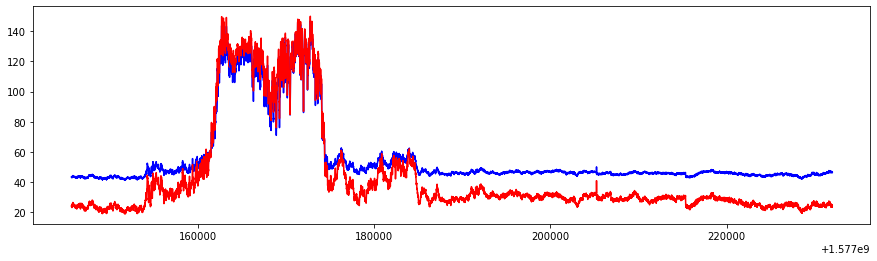

In [10]:
plt.figure(figsize=(15,4))
for f in fwps[:]:
    nc = Dataset(f)
    plt.plot(nc.variables['Time'][:],nc.variables['Liquid-water-path'][:],'blue')
    plt.plot(nc.variables['Time'][:],nc.variables['Liquid-water-path-RPG'][:],'red')
    print(f, np.min(nc.variables['Direct-detection-brightness-temp'][:]))